    
    Análise Exploratória de Dados: Realizar uma análise exploratória dos dados disponíveis para entender a distribuição das transações, identificar padrões e detectar possíveis características distintivas das transações fraudulentas.

    Pré-processamento dos Dados: Limpar e preparar os dados para o modelo de detecção de fraudes. Isso pode envolver o tratamento de valores ausentes, normalização de atributos numéricos, codificação de variáveis categóricas e balanceamento da distribuição das classes.

    Seleção e Treinamento do Modelo: Selecionar o algoritmo de aprendizado de máquina mais adequado para o problema, como Random Forest, SVM ou redes neurais, e treinar o modelo usando os dados rotulados. O conjunto de dados rotulados consistirá em transações marcadas como legítimas ou fraudulentas com base em análises anteriores.

    Avaliação do Modelo: Avaliar o desempenho do modelo usando métricas apropriadas, como precisão, recall, F1-score e curva ROC. Também é importante considerar a detecção de falsos positivos (transações legítimas classificadas erroneamente como fraudulentas) e falsos negativos (transações fraudulentas não detectadas).

    Implantação e Monitoramento em Tempo Real: Implementar o modelo treinado em um ambiente de produção, integrando-o ao sistema de pagamentos online da empresa. Monitorar constantemente as transações em tempo real, atribuindo pontuações de risco e tomando ações adequadas com base nas decisões do modelo.
    
    Aprimoramento Contínuo: Realizar atualizações periódicas do modelo à medida que novos dados e padrões de fraude emergem. Refinar o modelo com técnicas de aprendizado contínuo e incorporar feedback dos especialistas em detecção de fraudes para melhorar a eficácia do sistema ao longo do tempo.
    
    
    
   Dataset: data/fraud.csv

# Metadados

    passo: representa uma unidade de tempo onde 1 passo equivale a 1 hora

    tipo: tipo de transação online

    montante: o valor da transação

    nameOrig: cliente iniciando a transação

    oldbalanceOrg: saldo antes da transação

    newbalanceOrig: saldo após a transação

    nameDest: destinatário da transação

    oldbalanceDest: saldo inicial do destinatário antes da transação

    newbalanceDest: o novo saldo do destinatário após a transação

    isFraud: transação fraudulenta

# PASSO 00 IMPORTS

In [1]:
import math
import pandas as pd
import numpy  as np
import inflection
import requests
import random
import pickle
import warnings
import xgboost as xgb
import seaborn as sns


from boruta               import BorutaPy
from scipy                import stats      as ss
from matplotlib           import pyplot     as plt
from IPython.core.display import HTML
from IPython.display      import Image

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler , LabelEncoder
from sklearn.ensemble import RandomForestClassifier


warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_csv('../fraud.csv')

In [3]:
df_raw.columns

Index(['step', 'tipo', 'quantidade', 'nomeOrig', 'saldoAntigoOrig',
       'novoSaldoOrig', 'nomeDest', 'saldoAntigoDest', 'novoSaldoDest',
       'ehFraude', 'ehFraudeSinalizada'],
      dtype='object')

In [4]:
df_raw.shape

(6362620, 11)

# PASSO 01 DATA DESCRIPTION

Nesta seção de data description vamos analisar alguns aspectos estruturais do nosso dataset. Vamos analisar se existe algum valor faltante, analisar se existem valores nulos, verificar os tipos das nossas variáveis, verificar a distribuição na nossa variável 'target' com objetivo de separar dados de treino e desde e não causar viéses na análise exploratória.

In [5]:
df_raw.isnull().sum()

step                  0
tipo                  0
quantidade            0
nomeOrig              0
saldoAntigoOrig       0
novoSaldoOrig         0
nomeDest              0
saldoAntigoDest       0
novoSaldoDest         0
ehFraude              0
ehFraudeSinalizada    0
dtype: int64

In [6]:
df_raw.isna().sum()

step                  0
tipo                  0
quantidade            0
nomeOrig              0
saldoAntigoOrig       0
novoSaldoOrig         0
nomeDest              0
saldoAntigoDest       0
novoSaldoDest         0
ehFraude              0
ehFraudeSinalizada    0
dtype: int64

In [7]:
df_raw.dtypes

step                    int64
tipo                   object
quantidade            float64
nomeOrig               object
saldoAntigoOrig       float64
novoSaldoOrig         float64
nomeDest               object
saldoAntigoDest       float64
novoSaldoDest         float64
ehFraude                int64
ehFraudeSinalizada      int64
dtype: object

In [8]:
print('Número de linhas é: {}' .format(df_raw.shape[0]))
print('Número de colunas é: {}' .format(df_raw.shape[1]))

Número de linhas é: 6362620
Número de colunas é: 11


# 1.2 Estatísticas Descritivas

In [9]:
num_attributes = df_raw.select_dtypes(include=['int64' , 'float64'])
cat_attributes = df_raw.select_dtypes(exclude=['int64' , 'float64'])

## 1.2.1 Variáveis Numéricas

In [10]:
#Central Tendency - mean , median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion - std , min , max , range , skew , kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis',]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,step,1.0,7.430000e+02,7.420000e+02,2.433972e+02,239.000,1.423320e+02,0.375177,0.329071
1,quantidade,0.0,9.244552e+07,9.244552e+07,1.798619e+05,74871.940,6.038582e+05,30.993949,1797.956705
2,saldoAntigoOrig,0.0,5.958504e+07,5.958504e+07,8.338831e+05,14208.000,2.888242e+06,5.249136,32.964879
3,novoSaldoOrig,0.0,4.958504e+07,4.958504e+07,8.551137e+05,0.000,2.924048e+06,5.176884,32.066985
4,saldoAntigoDest,0.0,3.560159e+08,3.560159e+08,1.100702e+06,132705.665,3.399180e+06,19.921758,948.674125
5,novoSaldoDest,0.0,3.561793e+08,3.561793e+08,1.224996e+06,214661.440,3.674129e+06,19.352302,862.156508
6,ehFraude,0.0,1.000000e+00,1.000000e+00,1.290820e-03,0.000,3.590479e-02,27.779538,769.702982
7,ehFraudeSinalizada,0.0,1.000000e+00,1.000000e+00,2.514687e-06,0.000,1.585775e-03,630.603629,397659.062500


## 1.2.2 Variáveis Categoricas

In [11]:
cat_attributes.apply( lambda x: x.unique().shape[0])

tipo              5
nomeOrig    6353307
nomeDest    2722362
dtype: int64

In [12]:
df_raw.tipo.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: tipo, dtype: int64

<AxesSubplot:xlabel='tipo', ylabel='count'>

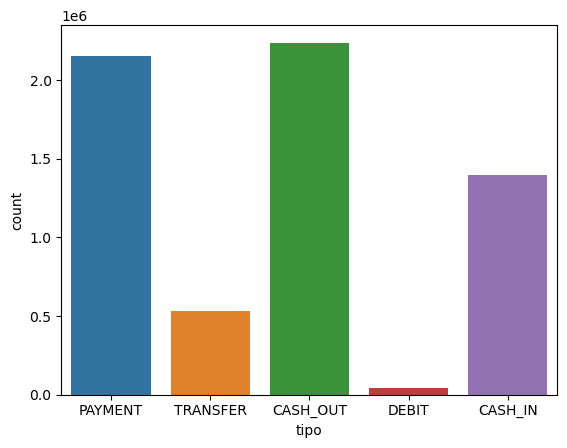

In [13]:
sns.countplot(df_raw, x='tipo')

In [14]:
df_raw.ehFraude.value_counts()

0    6354407
1       8213
Name: ehFraude, dtype: int64

<AxesSubplot:xlabel='ehFraude', ylabel='count'>

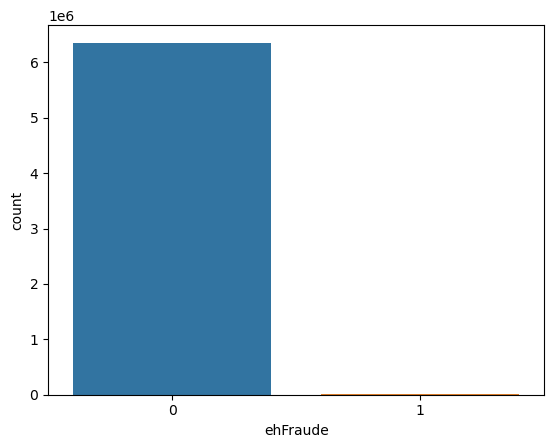

In [15]:
sns.countplot(df_raw,x='ehFraude')

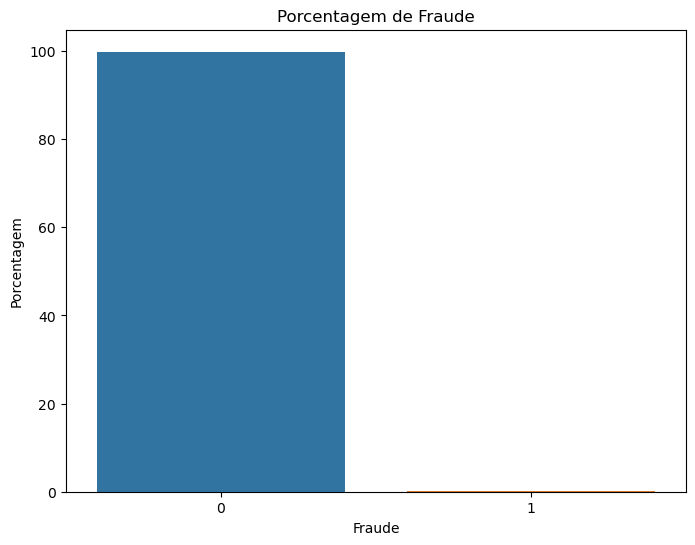

0    99.870918
1     0.129082
Name: ehFraude, dtype: float64

In [16]:
percentages = df_raw['ehFraude'].value_counts(normalize=True) * 100

# Plotando o gráfico
plt.figure(figsize=(8, 6))
sns.barplot(x=percentages.index, y=percentages.values)
plt.title('Porcentagem de Fraude')
plt.xlabel('Fraude')
plt.ylabel('Porcentagem')
plt.show()

percentages

In [17]:
df_raw.ehFraudeSinalizada.value_counts()

0    6362604
1         16
Name: ehFraudeSinalizada, dtype: int64

<AxesSubplot:xlabel='ehFraudeSinalizada', ylabel='count'>

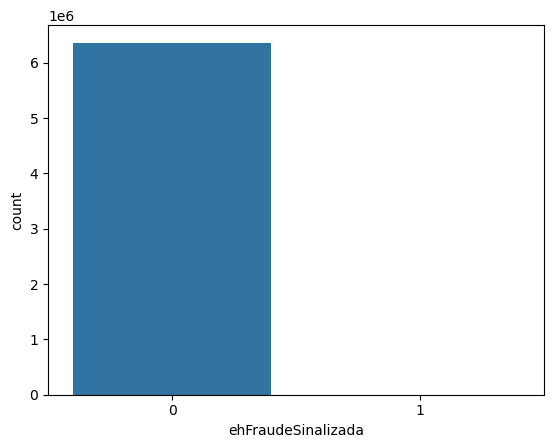

In [18]:
sns.countplot(df_raw,x='ehFraudeSinalizada')

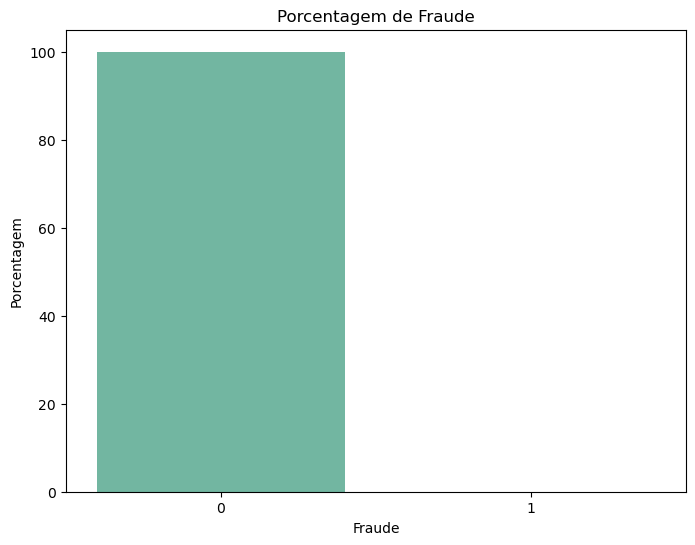

In [19]:
percentages = df_raw['ehFraudeSinalizada'].value_counts(normalize=True) * 100

# Plotando o gráfico
plt.figure(figsize=(8, 6))
sns.barplot(x=percentages.index, y=percentages.values, palette='Set2')
plt.title('Porcentagem de Fraude')
plt.xlabel('Fraude')
plt.ylabel('Porcentagem')
plt.show()


Sendo o número de fraudes sinalizadas extremamente baixo quando comparado ao número de transações que não são fraude, vamos eliminar essa variável do nosso dataframe. Ficaremos apenas com a variável targe de 'ehFraude'. Um problema que desde já devemos nos preocupar é o problema de desbalanceamento de classe. Note que temos muitos mais transações marcadas como normais do que fraudulentas, logo durante a construção de um modelo de ML para prever essas transações, devemos olhar para diferentes métricas de avaliação. A acaurácia sozinha não é uma boa métrica pois o algoritmo pode estar apenas acertando as transações que são normais e a acurácia(VP+VN)/(VP+VN+FP+FN) será alta. Outra métrica que não deve ser vista sozinha é a precisão pois sendo ela a relação entre (VP/VP+FP) corremos o risco de treinar um algoritmo que identifique muito bem as verdadeiras fraudes, porém com custo de inferir que muitas transações normais sejam consideras fraudulentas. Logo, as métricas devem ser olhadas em conjunto dando importância para análise do F1-score e análise da curva de precision-recall. 

Antes de seguirmos, irei fazer uma divisão estratificada dos dado com intuito de validar o modelo e fazer o controle de overfiting. Vamos dividir os dados na proporção 80(continuidade da modelagem) 20(validação do modelo). Não estamos separando dados para teste ainda, estamos apenas separando uma amostra para validação do modelo. 

In [20]:
df_raw.drop(['ehFraudeSinalizada'], axis=1,inplace=True)
df_raw.head()

,step,tipo,quantidade,nomeOrig,saldoAntigoOrig,novoSaldoOrig,nomeDest,saldoAntigoDest,novoSaldoDest,ehFraude
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [21]:
# Divisão estratificada
train_data, val_data = train_test_split(df_raw, test_size=0.2, stratify=df_raw['ehFraude'], random_state=42)

# Verificando as proporções
print("Proporção de fraudes no conjunto de treinamento:", train_data['ehFraude'].value_counts(normalize=True)*100)
print("Proporção de fraudes no conjunto de validação:", val_data['ehFraude'].value_counts(normalize=True)*100)

Proporção de fraudes no conjunto de treinamento: 0    99.870926
1     0.129074
Name: ehFraude, dtype: float64
Proporção de fraudes no conjunto de validação: 0    99.870887
1     0.129113
Name: ehFraude, dtype: float64


Temos a mesma proporção no conjunto que usaremos para treino e mesma proporção no conjunto que usaremos para validar.

# PASSO 03 Exploratory Data Analysis (EDA)

Vamos fazer a EDA apenas nos dados separados para Treino. 

# 3.1 Análise univariada

In [22]:
train_data.columns

Index(['step', 'tipo', 'quantidade', 'nomeOrig', 'saldoAntigoOrig',
       'novoSaldoOrig', 'nomeDest', 'saldoAntigoDest', 'novoSaldoDest',
       'ehFraude'],
      dtype='object')

<AxesSubplot:xlabel='tipo', ylabel='count'>

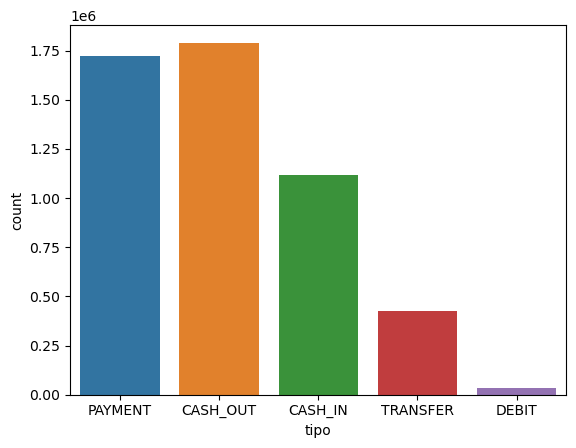

In [23]:
sns.countplot(train_data,x='tipo')

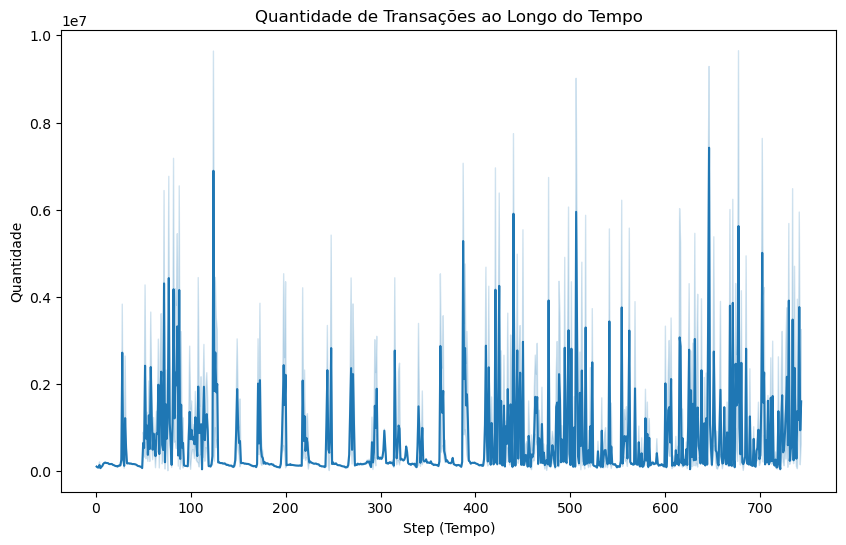

In [44]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=train_data, x='step', y='quantidade')
plt.title('Quantidade de Transações ao Longo do Tempo')
plt.xlabel('Step (Tempo)')
plt.ylabel('Quantidade')
plt.show()

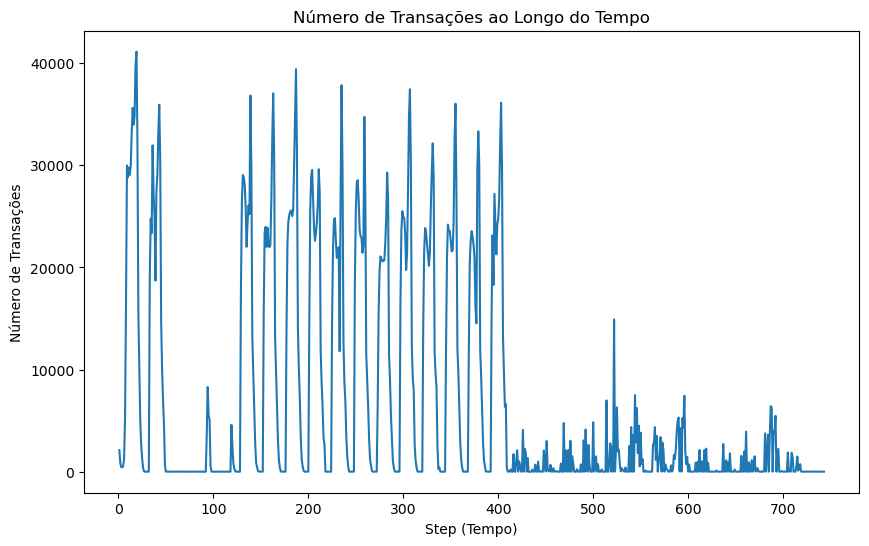

In [45]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=train_data.groupby('step').size())
plt.title('Número de Transações ao Longo do Tempo')
plt.xlabel('Step (Tempo)')
plt.ylabel('Número de Transações')
plt.show()


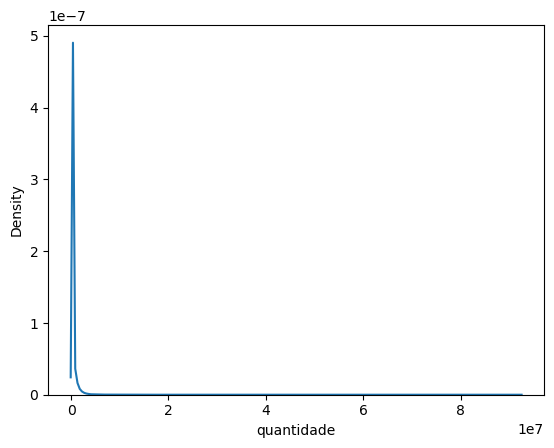

In [25]:
sns.kdeplot(train_data['quantidade']);

<Figure size 1000x600 with 0 Axes>

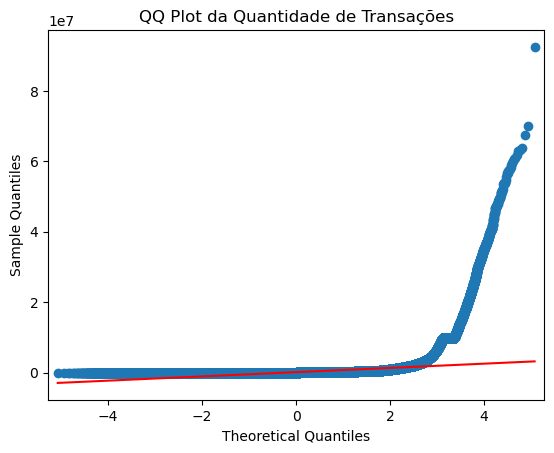

In [49]:
import statsmodels.api as sm
plt.figure(figsize=(10, 6))
sm.qqplot(train_data['quantidade'], line='s')
plt.title('QQ Plot da Quantidade de Transações')
plt.show()

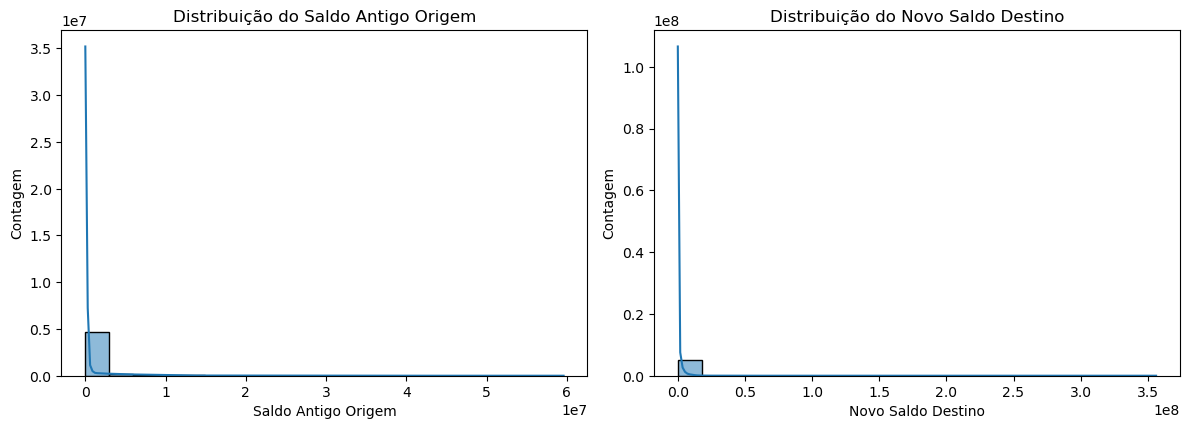

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(train_data['saldoAntigoOrig'], bins=20, kde=True)
plt.title('Distribuição do Saldo Antigo Origem')
plt.xlabel('Saldo Antigo Origem')
plt.ylabel('Contagem')

plt.subplot(2, 2, 2)
sns.histplot(train_data['novoSaldoDest'], bins=20, kde=True)
plt.title('Distribuição do Novo Saldo Destino')
plt.xlabel('Novo Saldo Destino')
plt.ylabel('Contagem')

plt.tight_layout()
plt.show()

# 3.2 Análise Bivariada

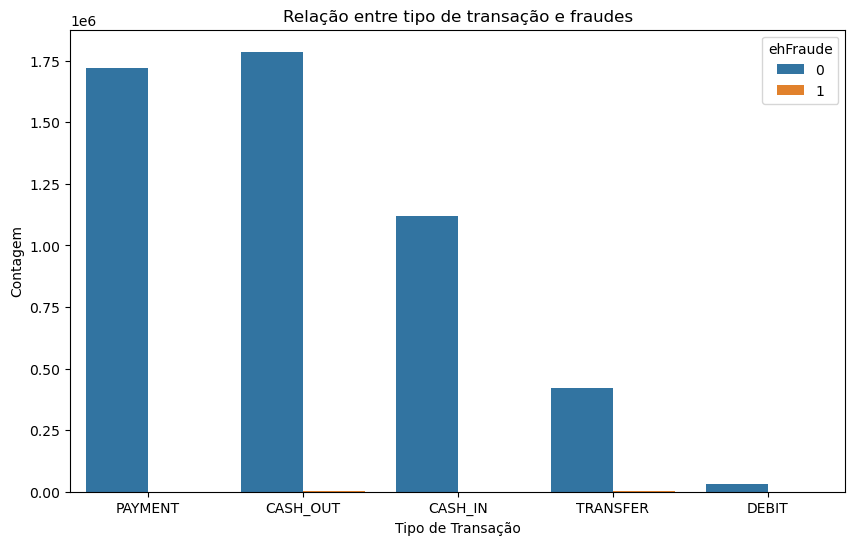

In [29]:
#Relação entre o tipo de transação e as fraudes:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='tipo', hue='ehFraude')
plt.title('Relação entre tipo de transação e fraudes')
plt.xlabel('Tipo de Transação')
plt.ylabel('Contagem')
plt.show()

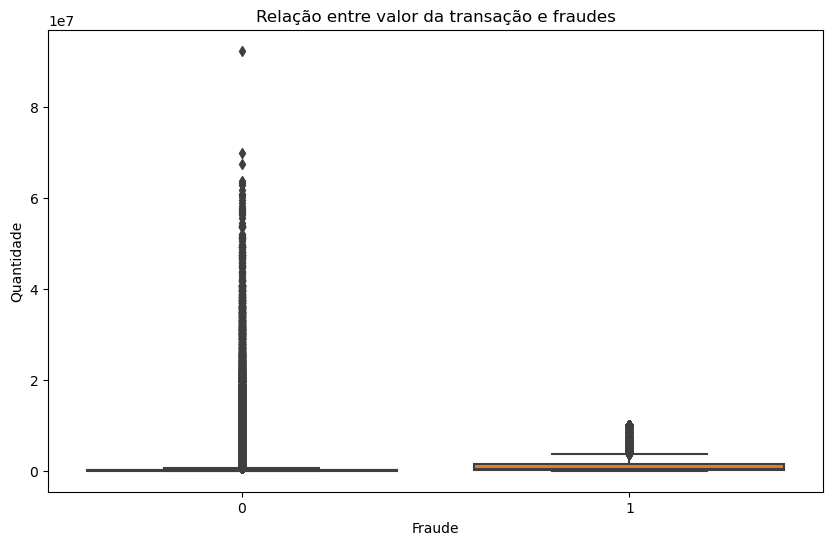

In [31]:
# Relação entre o valor da transação e as fraudes:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_data, x='ehFraude', y='quantidade')
plt.title('Relação entre valor da transação e fraudes')
plt.xlabel('Fraude')
plt.ylabel('Quantidade')
plt.show()

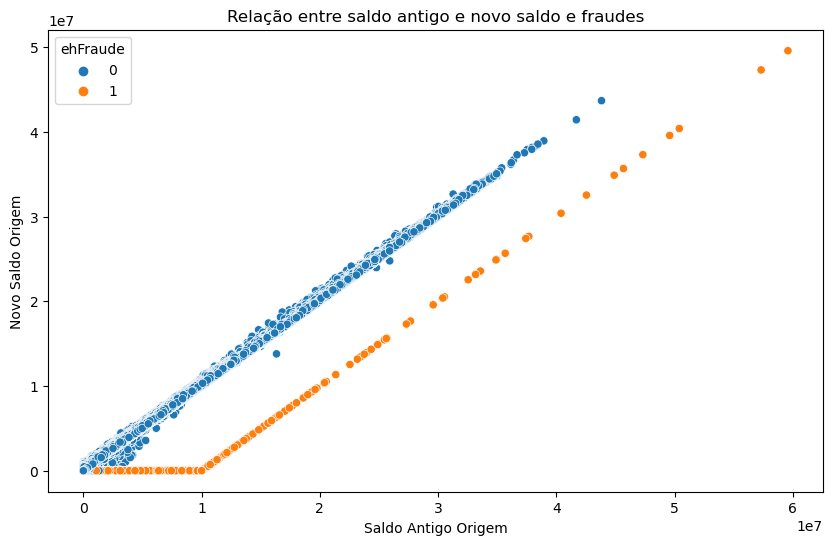

In [35]:
#Relação entre saldo antigo e novo saldo e as fraudes:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='saldoAntigoOrig', y='novoSaldoOrig', hue='ehFraude')
plt.title('Relação entre saldo antigo e novo saldo e fraudes')
plt.xlabel('Saldo Antigo Origem')
plt.ylabel('Novo Saldo Origem')
plt.show()

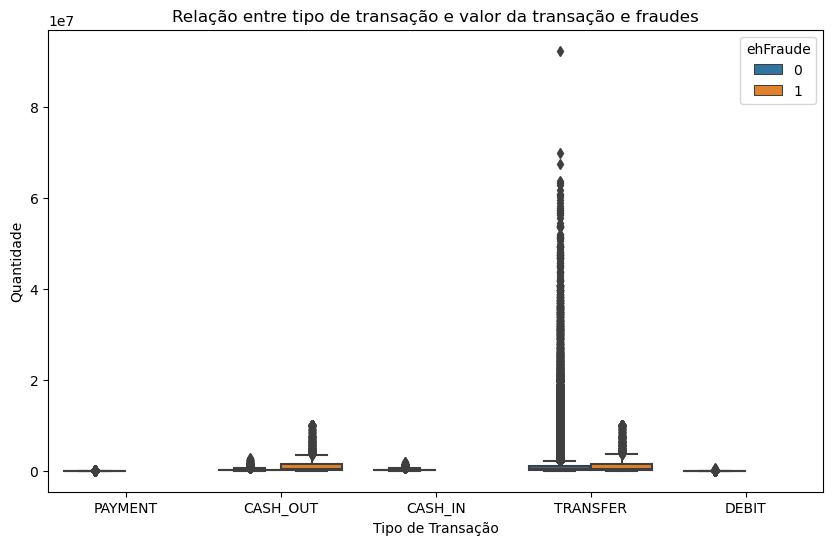

In [36]:
#Relação entre o tipo de transação e o valor da transação:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_data, x='tipo', y='quantidade', hue='ehFraude')
plt.title('Relação entre tipo de transação e valor da transação e fraudes')
plt.xlabel('Tipo de Transação')
plt.ylabel('Quantidade')
plt.show()

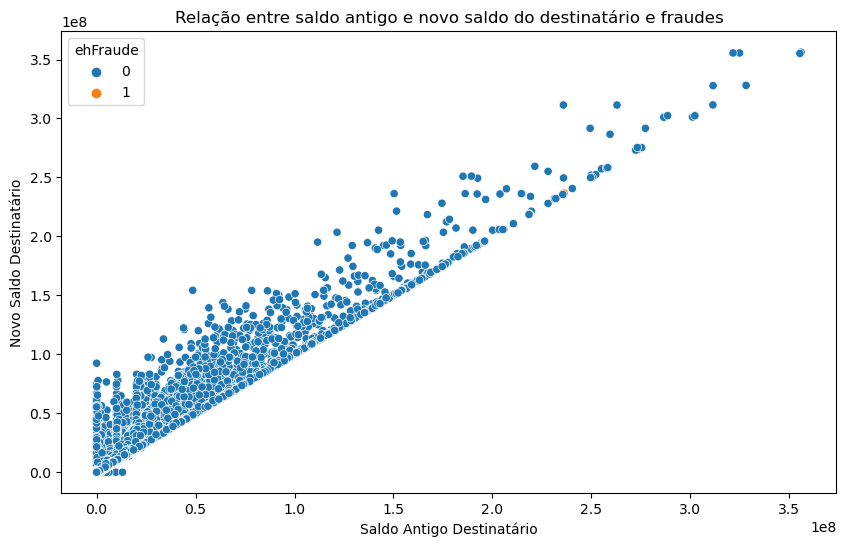

In [37]:
#Relação entre o saldo antigo do destinatário e o novo saldo do destinatário e as fraudes:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='saldoAntigoDest', y='novoSaldoDest', hue='ehFraude')
plt.title('Relação entre saldo antigo e novo saldo do destinatário e fraudes')
plt.xlabel('Saldo Antigo Destinatário')
plt.ylabel('Novo Saldo Destinatário')
plt.show()

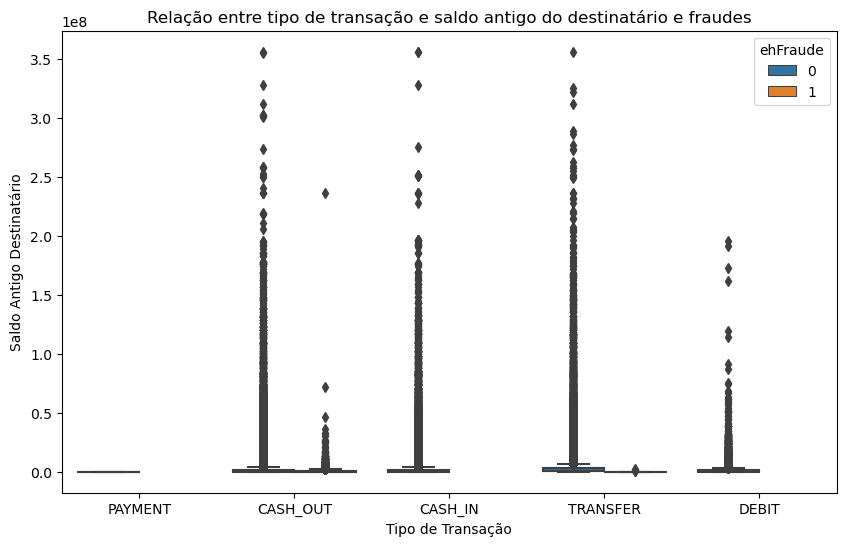

In [38]:
#Relação entre o tipo de transação e o saldo antigo do destinatário:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_data, x='tipo', y='saldoAntigoDest', hue='ehFraude')
plt.title('Relação entre tipo de transação e saldo antigo do destinatário e fraudes')
plt.xlabel('Tipo de Transação')
plt.ylabel('Saldo Antigo Destinatário')
plt.show()


# 3.3 Análise Multivariada

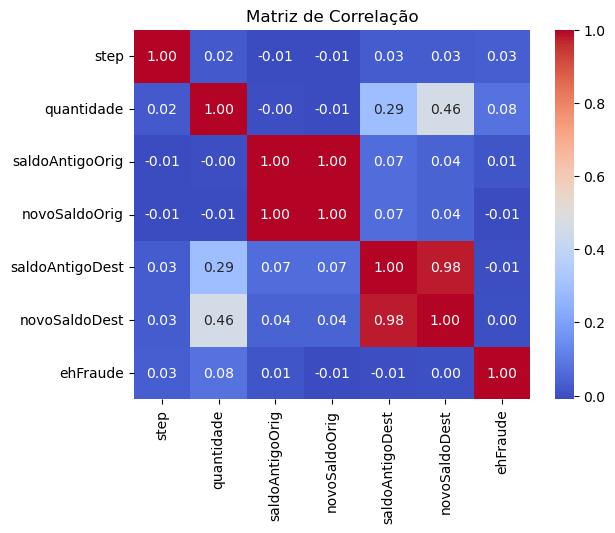

In [39]:
correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

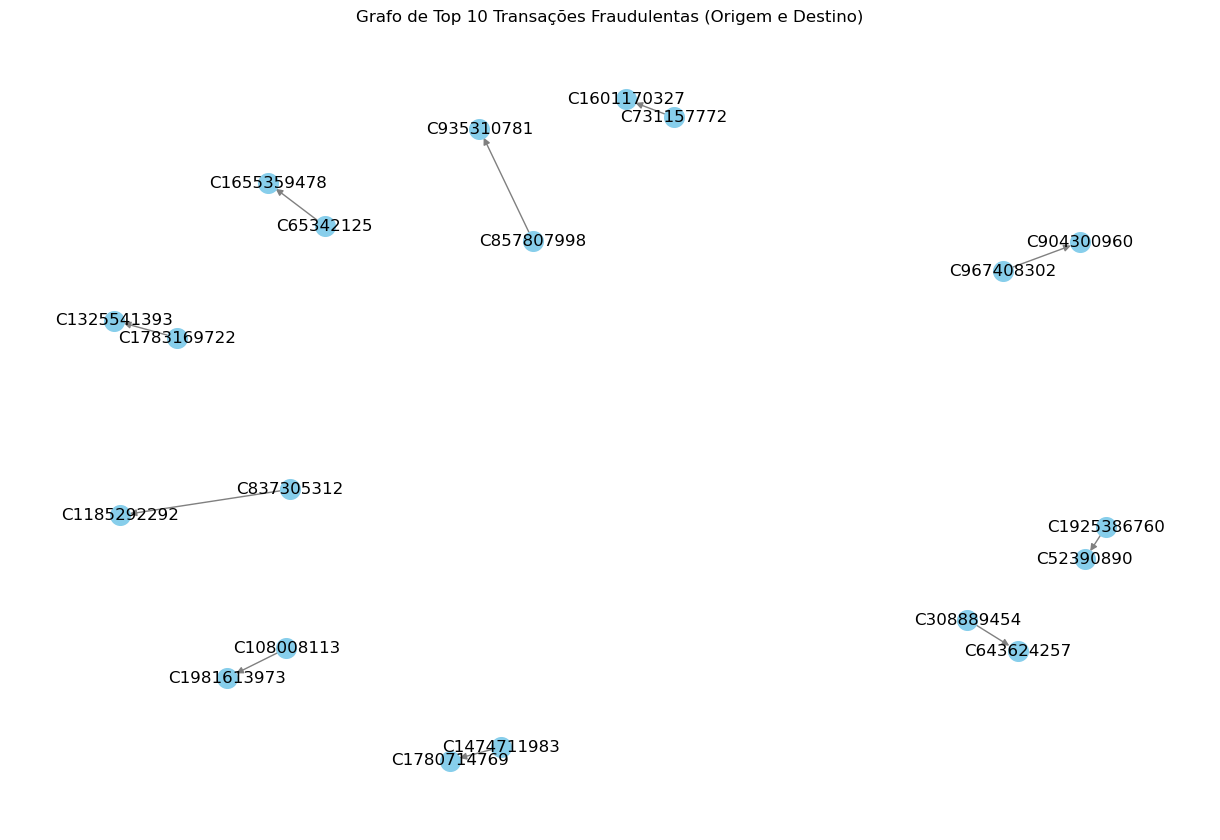

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

# Crie um grafo direcionado
G = nx.DiGraph()

fraudulent_transactions = train_data[train_data['ehFraude'] == 1]

# Obtenha as top 10 transações de origem e destino fraudulentas
top_orig_transactions = fraudulent_transactions['nomeOrig'].value_counts().head(10)
top_dest_transactions = fraudulent_transactions['nomeDest'].value_counts().head(10)

# Adicione as arestas representando as transações
for orig, dest in zip(top_orig_transactions.index, top_dest_transactions.index):
    G.add_edge(orig, dest)

# Defina a posição dos nós no gráfico
pos = nx.spring_layout(G)

# Plote o grafo
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=200, node_color='skyblue', edge_color='gray', arrowsize=10)
plt.title('Grafo de Top 10 Transações Fraudulentas (Origem e Destino)')
plt.show()

#Apartir dessa análise, podemos marcar com 1 todas as contas origens e destino como fraudulentas.

Nota-se que a análise de contas fraudulentas fica prejudicada devido ao baixo número de transações detetadas como fraudulentas. Neste caso, podemos seguir adontando a estrégia de fazer reamostragem de dados. A reamostragem de dados é uma alternativa que pode ser seguida, porém é importante ter cuidado com as técnicas e utilizando as métricas adequadas para tal abordagem.

# PASSO 04 Variable Filtering

Vamos iniciar essa seção filtrando todos as colunas do nosso dataset que não iremos utilizar. 

In [51]:
train_data.columns
#utilizaremos todas as colunas, pois já filtramos anteriormente as colunas que não serão utilizadas.

Index(['step', 'tipo', 'quantidade', 'nomeOrig', 'saldoAntigoOrig',
       'novoSaldoOrig', 'nomeDest', 'saldoAntigoDest', 'novoSaldoDest',
       'ehFraude'],
      dtype='object')

# PASSO 05 Data Preparation

## 5.1 Normalization

## 5.2 Rescaling

Na seção 1(data describe), fizemos o cálculo de alguma medidas como: média, moda e mediana (tendência central) e também medidas de dispersão: desvio padrão e variância. Logo, analisando-as, percebe-se claramente que suas distribuições são diferentes o que pode gerar problemas quando tentarmos contruir modelos utilizando algoritmos específicos, como  KNN. Levando em consideração que temos poucos dados de fraude e qualquer modificação que fizermos nos dados pode nos trazer problemas com viéses, vamos optar por não utilizar o algortimo KNN e não fazer normalizanão nem rescaling dos nossos dados. 

## 5.3 Transaformation

### 5.3.1 Encoding

Vamos agora fazer o encoding das variáveis categóricas.

In [54]:
cat_attributes.columns

Index(['tipo', 'nomeOrig', 'nomeDest'], dtype='object')

In [55]:
train_data.tipo.unique()

array(['PAYMENT', 'CASH_OUT', 'CASH_IN', 'TRANSFER', 'DEBIT'],
      dtype=object)

Note que essa variável tem uma importância substâncial para a diferenciação de transações fraudulenta. Apesar de na análise biavariada termos encontrado mais transações fraudulentas em cashout e transferências, vamos optar por fazer o encoding dessas variáveis utilizando o onehot enconding, ou seja, usando variáveis dummys, apesar dessa estratégia aumentar a dimensionalidade do dataset, vamos optar por essa estratégia ao invés de fazer uma ponderação espúria com essa variável.

In [52]:
df_raw.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [56]:
df_train_data = pd.get_dummies(train_data,columns=['tipo'])
df_train_data.head(5)

,step,quantidade,nomeOrig,saldoAntigoOrig,novoSaldoOrig,nomeDest,saldoAntigoDest,novoSaldoDest,ehFraude,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER
292779,15,9914.74,C482751146,44248.00,34333.26,M1651188591,0.00,0.00,0,0,0,0,1,0
499763,20,6854.53,C188264521,0.00,0.00,M1469015863,0.00,0.00,0,0,0,0,1,0
2970411,231,361211.80,C593201095,0.00,0.00,C1985763166,489745.16,850956.95,0,0,1,0,0,0
3137549,236,7083.51,C1617277615,0.00,0.00,M1529547196,0.00,0.00,0,0,0,0,1,0
1500682,143,218019.51,C1705563354,13045685.58,13263705.09,C2121401221,2438123.98,2220104.47,0,1,0,0,0,0


In [65]:
train_data['ehFraude'].unique()

array([0, 1])

    Temos duas variáveis categóricas que precisam passar por enconding, são os nomes de origem e nomes de destino. Vamos fazer o enconding dessas variáveis, utilizando o target_enconding ('Mean Enconding').  
    
    Utilizarei essa abordagem pensando na finalidade de uso desse modelo, imagine que esse modelo será usando para interroper uma transação que está sendo suspeita de fraude, havendo alguma das pontas com suspeita de fraude a transação pode ser barrada pelo modelo.

In [66]:
origem_fraudulenta = train_data.groupby('nomeOrig')['ehFraude'].mean()
origem_fraudulenta

nomeOrig
C1000000639    0.0
C1000001337    0.0
C1000002591    0.0
C1000003372    0.0
C1000003615    0.0
              ... 
C999995025     0.0
C999996950     0.0
C999998175     0.0
C999999254     0.0
C999999784     0.0
Name: ehFraude, Length: 5084156, dtype: float64

In [69]:
df_train_data['nomeOrig_encoded'] = train_data['nomeOrig'].map(origem_fraudulenta)

df_train_data

,step,quantidade,nomeOrig,saldoAntigoOrig,novoSaldoOrig,nomeDest,saldoAntigoDest,novoSaldoDest,ehFraude,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER,nomeOrig_encoded
292779,15,9914.74,C482751146,44248.00,34333.26,M1651188591,0.00,0.00,0,0,0,0,1,0,0.0
499763,20,6854.53,C188264521,0.00,0.00,M1469015863,0.00,0.00,0,0,0,0,1,0,0.0
2970411,231,361211.80,C593201095,0.00,0.00,C1985763166,489745.16,850956.95,0,0,1,0,0,0,0.0
3137549,236,7083.51,C1617277615,0.00,0.00,M1529547196,0.00,0.00,0,0,0,0,1,0,0.0
1500682,143,218019.51,C1705563354,13045685.58,13263705.09,C2121401221,2438123.98,2220104.47,0,1,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524870,153,1895.99,C1302053063,0.00,0.00,M1494049570,0.00,0.00,0,0,0,0,1,0,0.0
5834821,402,347110.99,C788162540,103785.00,0.00,C1771727447,87871.75,434982.74,0,0,1,0,0,0,0.0
4182953,304,13259.63,C545341724,0.00,0.00,M253734860,0.00,0.00,0,0,0,0,1,0,0.0
3985280,298,24122.92,C1831600144,0.00,0.00,M1382629737,0.00,0.00,0,0,0,0,1,0,0.0


In [71]:
destino_fraudulenta = train_data.groupby('nomeDest')['ehFraude'].mean()
destino_fraudulenta

nomeDest
C1000004082    0.0
C1000004940    0.0
C1000013769    0.0
C100001587     0.0
C1000015936    0.0
              ... 
M999998566     0.0
M99999900      0.0
M999999089     0.0
M999999543     0.0
M999999784     0.0
Name: ehFraude, Length: 2266013, dtype: float64

In [73]:
df_train_data['nomeDest_encoded'] = train_data['nomeDest'].map(destino_fraudulenta)
df_train_data

,step,quantidade,nomeOrig,saldoAntigoOrig,novoSaldoOrig,nomeDest,saldoAntigoDest,novoSaldoDest,ehFraude,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER,nomeOrig_encoded,nomeDest_encoded
292779,15,9914.74,C482751146,44248.00,34333.26,M1651188591,0.00,0.00,0,0,0,0,1,0,0.0,0.0
499763,20,6854.53,C188264521,0.00,0.00,M1469015863,0.00,0.00,0,0,0,0,1,0,0.0,0.0
2970411,231,361211.80,C593201095,0.00,0.00,C1985763166,489745.16,850956.95,0,0,1,0,0,0,0.0,0.0
3137549,236,7083.51,C1617277615,0.00,0.00,M1529547196,0.00,0.00,0,0,0,0,1,0,0.0,0.0
1500682,143,218019.51,C1705563354,13045685.58,13263705.09,C2121401221,2438123.98,2220104.47,0,1,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524870,153,1895.99,C1302053063,0.00,0.00,M1494049570,0.00,0.00,0,0,0,0,1,0,0.0,0.0
5834821,402,347110.99,C788162540,103785.00,0.00,C1771727447,87871.75,434982.74,0,0,1,0,0,0,0.0,0.0
4182953,304,13259.63,C545341724,0.00,0.00,M253734860,0.00,0.00,0,0,0,0,1,0,0.0,0.0
3985280,298,24122.92,C1831600144,0.00,0.00,M1382629737,0.00,0.00,0,0,0,0,1,0,0.0,0.0


Essa transformação substituirá os nomes de origem e destino pelos percentuais médios de transações fraudulentas associadas a esses nomes. Isso pode ser útil para ajudar o modelo a identificar padrões de comportamento suspeitos nos dados.

In [78]:
df_train_data.columns

Index(['step', 'quantidade', 'nomeOrig', 'saldoAntigoOrig', 'novoSaldoOrig',
       'nomeDest', 'saldoAntigoDest', 'novoSaldoDest', 'ehFraude',
       'tipo_CASH_IN', 'tipo_CASH_OUT', 'tipo_DEBIT', 'tipo_PAYMENT',
       'tipo_TRANSFER', 'nomeOrig_encoded', 'nomeDest_encoded'],
      dtype='object')

Feitas essas transformações podemos eliminar do nosso dataset todas as colunas que foram feitas o enconding.

In [86]:
df_train_data.drop(['nomeOrig','nomeDest'],axis=1,inplace=True)

In [88]:
df_train_data.head()

,step,quantidade,saldoAntigoOrig,novoSaldoOrig,saldoAntigoDest,novoSaldoDest,ehFraude,tipo_CASH_IN,tipo_CASH_OUT,tipo_DEBIT,tipo_PAYMENT,tipo_TRANSFER,nomeOrig_encoded,nomeDest_encoded
292779,15,9914.74,44248.00,34333.26,0.00,0.00,0,0,0,0,1,0,0.0,0.0
499763,20,6854.53,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0.0,0.0
2970411,231,361211.80,0.00,0.00,489745.16,850956.95,0,0,1,0,0,0,0.0,0.0
3137549,236,7083.51,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0.0,0.0
1500682,143,218019.51,13045685.58,13263705.09,2438123.98,2220104.47,0,1,0,0,0,0,0.0,0.0


Podemos agora sem fazer seleção de features ou reamostragem dos dados. Construir um modelo rápido para servir de baseline das nossas construções seguintes. Vamos utilizar a regressão logística como baseline.

In [89]:
X = df_train_data.drop(columns=['ehFraude'])
y = df_train_data['ehFraude']

In [ ]:
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

def calculate_metrics(model, X, y):
    scoring = {'precision':'precision','recall':'recall','f1':'f1'}
    scores = cross_validate(model, X,y,cv=5,scoring=scoring)
    
    return {
        'precision_mean': scores['test_precision'].mean(),
        'recall_mean': scores['test_recall'].mean(),
        'f1_mean': scores['test_f1'].mean()}

modelo = LogisticRegression()

metricas = calculate_metrics(modelo,X,y)

In [ ]:
metricas

# PASSO 06 Feature Selection

# PASSO 07 Machine Learning Modelling

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
df_raw.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [58]:
x = np.array(df_raw[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig']])
y = np.array(df_raw['isFraud'])

In [59]:
from sklearn.tree import DecisionTreeClassifier
xtrain, xtest , ytrain, ytest = train_test_split(x,y,test_size=0.10,random_state=42)
model = DecisionTreeClassifier()
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.9997296711103287

In [64]:
features = np.array([[4, 500.60, 300.60, 1.0]])
print(model.predict(features))

['No Fraud']


# PASSO 08 Hyperparameter Fine tuning

# PASSO 09 Error Translate and Interpretation

# PASSO 10 Deploy Model to Production